In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [32]:
df= pd.read_csv('goodreads_reviews_shrink.csv')
print(df.shape)
df.head()


(1000000, 5)


,user_id,book_id,review_id,review_text,rating
0,8842281e1d1347389f2ab93d60773d4d,24375664,5cd416f3efc3f944fce4ce2db2290d5e,Mind blowingly cool. Best science fiction I've...,5
1,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,This is a special book. It started slow for ab...,5
2,8842281e1d1347389f2ab93d60773d4d,6392944,5e212a62bced17b4dbe41150e5bb9037,I haven't read a fun mystery book in a while a...,3
3,8842281e1d1347389f2ab93d60773d4d,22078596,fdd13cad0695656be99828cd75d6eb73,"Fun, fast paced, and disturbing tale of murder...",4
4,8842281e1d1347389f2ab93d60773d4d,6644782,bd0df91c9d918c0e433b9ab3a9a5c451,A fun book that gives you a sense of living in...,4


In [33]:
df.isnull().sum()

user_id          0
book_id          0
review_id        0
review_text    465
rating           0
dtype: int64

In [34]:
df = df.dropna(subset=['review_text'])
df.isnull().sum()


user_id        0
book_id        0
review_id      0
review_text    0
rating         0
dtype: int64

In [35]:
df.shape

(999535, 5)

In [36]:
print("number of unique books: ", len(df['book_id'].unique()))
print("number of unique reviews: ", len(df['review_id'].unique()))

number of unique books:  395468
number of unique reviews:  999535


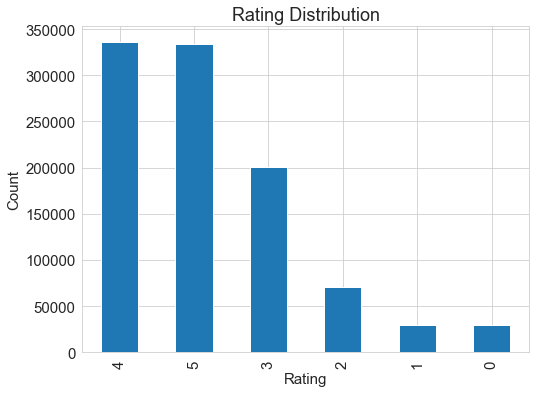

In [37]:
def plotHIST(df, col, xlab, ylab, title):
    sns.set_style("whitegrid")
    %matplotlib inline
    plt.figure(figsize=(8,6))
    plt.rc("font", size=15)
    df[col].value_counts(sort=True).plot(kind="bar")
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.show()

plotHIST(df, "rating","Rating", "Count", "Rating Distribution")

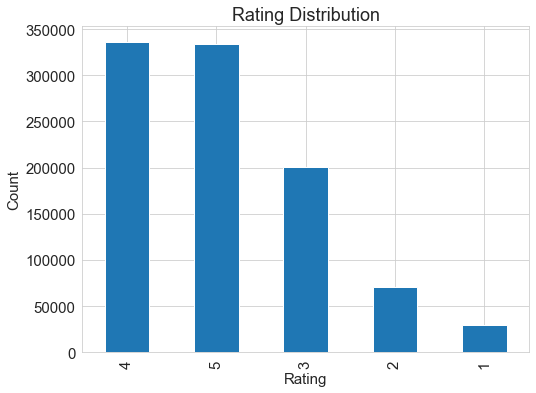

4    336260
5    334041
3    200271
2     70641
1     29166
Name: rating, dtype: int64

In [38]:
# remove rows with rating 0 (not rated)
df = df[df['rating'] != 0]
df.shape

plotHIST(df, "rating","Rating", "Count", "Rating Distribution")
df['rating'].value_counts()

In [39]:
# showing books
df['book_id'].value_counts()

11870085    1293
2767052      948
8442457      725
7260188      721
22557272     720
            ... 
16193865       1
18901793       1
18927423       1
24967821       1
15843480       1
Name: book_id, Length: 386266, dtype: int64

In [40]:
#there are books that have been rated only once
# SHRINKING THE DATASET BY REMOVING BOOKS THAT HAVE BEEN RATED LESS THAN 100 TIMES
counts = df['book_id'].value_counts()
df = df[df['book_id'].isin(counts[counts >= 50].index)]
print(df.shape)
df['book_id'].value_counts()

(157889, 5)


11870085    1293
2767052      948
8442457      725
7260188      721
22557272     720
            ... 
20342617      50
16101126      50
140082        50
14743         50
16147062      50
Name: book_id, Length: 1417, dtype: int64

In [41]:
df['user_id'].value_counts()

8e7e5b546a63cb9add8431ee6914cf59    273
c4f655f2ed79599a9259d7762313f3f3    263
b9c0d56438ee6342288737820c9cdcbf    239
08d805375530cc208801531ca7fdefbc    229
414d7ea1693ad9479b30c7c987a5f66b    220
                                   ... 
3111c6968e7bb3d1853fb12e9364ea69      1
8d7eebd66d43ab4c4c4efdf795c9e0bf      1
4ce688b2c0701649235983d2bb16ab90      1
4e4632eb54cfb1c5f2a699f6c54c1ef1      1
3fd461546a279bff6da8ef5a9df45da0      1
Name: user_id, Length: 15020, dtype: int64

In [42]:
# there are users that have rated only once
# SHRINKING THE DATASET BY REMOVING USERS THAT HAVE RATED LESS THAN 10 TIMES
counts = df["user_id"].value_counts()
df = df[df["user_id"].isin(counts[counts >= 10].index)]
print(df.shape)
df["user_id"].value_counts()

(123692, 5)


8e7e5b546a63cb9add8431ee6914cf59    273
c4f655f2ed79599a9259d7762313f3f3    263
b9c0d56438ee6342288737820c9cdcbf    239
08d805375530cc208801531ca7fdefbc    229
414d7ea1693ad9479b30c7c987a5f66b    220
                                   ... 
0222a127a23e48a309e362cfa4533933     10
3631de43c987d9af6b19ae47432705bb     10
8a4d6da65fc59a93345dddae65869510     10
033f8ea561f511d5a7a1193007e539a3     10
f131126e97b09f87010f4d419391ee9f     10
Name: user_id, Length: 4260, dtype: int64

In [43]:
print(df.shape)
df.head()


(123692, 5)


,user_id,book_id,review_id,review_text,rating
28,8842281e1d1347389f2ab93d60773d4d,22318578,5fe9882bfe4b0520a322820c4c55747d,5 stars for giving me a better framework for h...,5
30,8842281e1d1347389f2ab93d60773d4d,22551730,754710070f38e1c59a45f6a85473b836,Another hard to put down nonfiction book from ...,4
31,8842281e1d1347389f2ab93d60773d4d,22816087,d11954e6e9e9ddf52aed41d83ce43fa6,I love Stephenson - and this was another hit -...,5
47,8842281e1d1347389f2ab93d60773d4d,5064,da4757c50c0edb081ca124d33db8186b,"I tore through The Pillars of the Earth, and c...",5
54,8842281e1d1347389f2ab93d60773d4d,13526165,51fe3e46c7f8eb39f5623d1bd8bbbbfc,"My wife suggested I read this book, and I resi...",5


In [45]:
#number of unique users and books
print("Number of unique users: ", df["user_id"].nunique())
print("Number of unique books: ", df["book_id"].nunique())

Number of unique users:  4260
Number of unique books:  1417


In [46]:
df.to_csv("data_top.csv", index=False)

In [47]:
# CREATING USER-ITEM MATRIX
userBookRating = df.pivot_table(index=["user_id"], columns=["book_id"], values="rating")
print(userBookRating.shape)
userBookRating.head()

(4260, 1417)


book_id,1,2,3,5,6,11,21,33,34,152,...,29906980,29939230,30253864,30312891,30555488,30653853,30688435,31434883,32075671,33151805
user_id,,,,,,,,,,,,,,,,,,,,,
00254cd48d3d8a99ca9f0ed44fa69d5f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0028b5eebf06b43b321671ea39e7ca3c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
003b4e8b12a17f343186e981a26edc74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
004d5e96c8a318aeb006af50f8cc949c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,2.0,NaN,NaN,5.0,5.0,NaN
004f6d189c4546a39db2162986c0d9e1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
